<h3> 1. 필요한 라이브러리 모두 불러오기 </h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor

<h3> 2. 데이터를 살펴보기 위한 함수 설정하기 </h3>
<p> 저같은 경우에는 EDA를 할 때 기본적인 틀이 존재해서 함수로 설정하였습니다. </h3>

In [2]:
def data_info(df : pd.DataFrame) -> None:
    print('column의 개수 : ', len(df.columns))
    print('데이터의 개수 : ', len(df))
    print('데이터의 shape : ', df.shape)
    print('categorical 변수의 개수 : ', len(df.columns[df.dtypes == 'object']))
    print('categorical 컬럼 : ', df.columns[df.dtypes == 'object'])
    print('numerical 변수의 개수 : ', len(df.columns[df.dtypes != 'object']))
    print('numerical 컬럼 : ', df.columns[df.dtypes != 'object'])
    print('결측치 개수 : ', df.isnull().sum().sum())
    print('====================================================================')
    print('컬럼 이름 : ', df.columns)

In [3]:
def search_columns(df : pd.DataFrame, columns : str, target : str) -> None:
    print('컬럼명 : ', columns)
    print('컬럼 분포 ', df[columns].value_counts(normalize = True).sort_values(ascending = True))
    print('라벨 별 target 비율 : ', df.groupby(columns)[target].mean())

# 분류 문제에서만 사용
def search_target_ratio(df : pd.DataFrame, columns : str, target : str) -> None:
    return pd.crosstab(df[columns], df[target], margins = True, normalize = 'index').style.background_gradient(cmap = 'summer_r')


# 연속형 변수들에 대한 분포 확인하기
def numerical_plot(df : pd.DataFrame, columns : list, nrows : int, ncols : int, row_size : int, col_size : int) -> None:
    fig, axes = plt.subplots(nrows, ncols, figsize = (row_size, col_size))
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            sns.distplot(x = df[columns[count]], ax = axes[i][j])
            axes[i][j].set_title(columns[count] + 'column distribution')
            axes[i][j].set_xlabel(columns[count])
            count += 1

# 상관계수 확인하기
def correlation_matrix(df : pd.DataFrame, numerical_columns : list, figsize : tuple) -> None:
    colormap = plt.cm.PuBu
    plt.title('Pearson Corrleation of data')
    plt.figure(figsize = figsize)
    if len(numerical_columns) <= 20:
        sns.heatmap(df[numerical_columns].astype(float).corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})
    else:
        sns.heatmap(df[numerical_columns].astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap)

def describe_matrix(df : pd.DataFrame) -> pd.DataFrame:
    return df.describe()

# 범주형 변수에 대한 countplot
def column_bar_plot(df : pd.DataFrame, columns : str) -> None:
    sns.countplot(x = df[columns])
    
# 이상치 처리
def outlier_to_normal(x, lower_bound, upper_bound):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x
    
# 이상치 처리 -> Q3 이상 값에 대해서는 Q3 값으로 처리
def outlier_transform(train_df : pd.DataFrame, test_df : pd.DataFrame, 
                      columns : list) -> (pd.DataFrame, pd.DataFrame):
    for column in columns:
        q1 = np.percentile(train_df[column], 25)
        q3 = np.percentile(train_df[column], 75)
        lower_bound = q1 - 1.5 * (q3 - q1)
        upper_bound = q3 + 1.5 * (q3 - q1)
        train_df[column] = train_df[column].apply(lambda x : 
                                        outlier_to_normal(x, lower_bound, upper_bound))
        test_df[column] = test_df[column].apply(lambda x : 
                                                outlier_to_normal(x, lower_bound, upper_bound))
    return (train_df, test_df)
    
# 범주형 변수 => 라벨인코딩
from sklearn.preprocessing import LabelEncoder
def categorical_column_preprocessing(train_df : pd.DataFrame, test_df : pd.DataFrame, columns : list) -> (pd.DataFrame, pd.DataFrame):
    train_data = train_df.copy()
    test_data = test_df.copy()
    for column in columns:
        le = LabelEncoder()
        le.fit(train_data[column])
        print(column + ' label encoder classes', le.classes_)
        train_data[column] = le.transform(train_data[column])
        test_data[column] = le.transform(test_data[column])

    return (train_data, test_data)

# 표준화
def standard_scaler(train_df : pd.DataFrame, test_df : pd.DataFrame, categorical_columns, numeric_columns : list) -> (pd.DataFrame, pd.DataFrame):
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaler.fit(train_df[numeric_columns])
    x_scaled = pd.DataFrame(scaler.transform(train_df[numeric_columns]), columns = numeric_columns)
    x_test_scaled = pd.DataFrame(scaler.transform(test_df[numeric_columns]), columns = numeric_columns)

    train_data = pd.concat([train_df[categorical_columns], x_scaled], axis = 1)
    test_data = pd.concat([test_df[categorical_columns], x_test_scaled], axis = 1)
    return (train_data, test_data)

# 로그화
def log_transform(train_df : pd.DataFrame, test_df : pd.DataFrame, categorical_columns, numeric_columns : list) -> (pd.DataFrame, pd.DataFrame):

    train_df[numeric_columns] = np.log1p(train_df[numeric_columns])
    test_df[numeric_columns] = np.log1p(test_df[numeric_columns])
    return (train_df, test_df)

# 정규화(Minmax-scaler)
def minmax_scaler(train_df : pd.DataFrame, test_df : pd.DataFrame, categorical_columns, numeric_columns : list) -> (pd.DataFrame, pd.DataFrame):
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    scaler.fit(train_df[numeric_columns])
    x_scaled = pd.DataFrame(scaler.transform(train_df[numeric_columns]), columns = numeric_columns)
    x_test_scaled = pd.DataFrame(scaler.transform(test_df[numeric_columns]), columns = numeric_columns)

    train_data = pd.concat([train_df[categorical_columns], x_scaled], axis = 1)
    test_data = pd.concat([test_df[categorical_columns], x_test_scaled], axis = 1)
    return (train_data, test_data)

# 학습 / 테스트 분리하기
def train_test(X : pd.DataFrame, y : pd.DataFrame, test_size : float, random_state = 42) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = test_size, random_state = 42, stratify = y)
    return X_train, X_valid, y_train, y_valid

<h3> 3. 데이터 불러오기 및 데이터 전처리 </h3>

In [4]:
import random

random.seed(42)

train_df = pd.read_csv('train.csv').drop('ID', axis = 1).drop_duplicates().reset_index(drop = True)
test_df = pd.read_csv('test.csv').drop('ID', axis = 1)
submission_df = pd.read_csv('sample_submission.csv')

target = 'monthlyRent(us_dollar)'

<p> suburbName에 너무 많아서 라벨인코딩시에 부정적 영향(스케일이 큰 것을 크게 측정)을 줄 수 있어서 대체하였습니다. 또한, 일부분은 1개만 존재하거나 수가 적었기 때문에 다른 것을 통합하였습니다.</p>

In [5]:
train_df.loc[(train_df['suburbName'] == 'West Delhi'), 'suburbName'] = 'Delhi West'
train_df.loc[train_df['suburbName'] == 'North Delhi', 'suburbName'] = 'Delhi North'
train_df.loc[train_df['suburbName'] == 'Dwarka', 'suburbName'] = 'North West Delhi'
train_df.loc[train_df['suburbName'] == 'Rohini', 'suburbName'] = 'South West Delhi'
train_df.loc[train_df['propertyType'] == 'Villa', 'propertyType'] = 'Independent Floor'

test_df.loc[(test_df['suburbName'] == 'West Delhi'), 'suburbName'] = 'Delhi West'
test_df.loc[test_df['suburbName'] == 'North Delhi', 'suburbName'] = 'Delhi North'
test_df.loc[test_df['suburbName'] == 'Dwarka', 'suburbName'] = 'North West Delhi'
test_df.loc[test_df['suburbName'] == 'Rohini', 'suburbName'] = 'South West Delhi'
test_df.loc[test_df['propertyType'] == 'Villa', 'propertyType'] = 'Independent Floor'

<p> 위도와 경도에 대해서 군집화를 실행하고 각 군집 별로 라벨링을 붙였습니다.</p>

In [6]:
from sklearn.cluster import KMeans

x = train_df.loc[:, ['latitude', 'longitude']]
x_test = test_df.loc[:, ['latitude', 'longitude']]
kmeans = KMeans(4, init = 'k-means++',  n_init= 20)
kmeans.fit(x)

train_clusters = kmeans.predict(x)
test_clusters = kmeans.predict(x_test)

train_df['cluster'] = train_clusters
test_df['cluster'] = test_clusters

(76.6, 77.5)

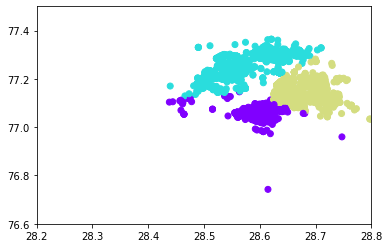

In [7]:
plt.scatter(train_df['latitude'], train_df['longitude'],
           c = train_df['cluster'], cmap = 'rainbow')
plt.xlim([28.2, 28.8])
plt.ylim([76.6, 77.5])

<p> 범주형 변수 처리, 이상치 처리, 표준화, 로그화를 진행하였습니다. 실제 학습시킨 데이터는 라벨인코딩/이상치/로그화 입니다.</p>

In [8]:
train_df_encoder, test_df_encoder = categorical_column_preprocessing(train_df, test_df, 
                                                     ['propertyType', 'suburbName'])

propertyType label encoder classes ['Apartment' 'Independent Floor' 'Independent House']
suburbName label encoder classes ['Delhi Central' 'Delhi East' 'Delhi North' 'Delhi South' 'Delhi West'
 'North West Delhi' 'Other' 'South West Delhi']


In [9]:
numerical_columns = ['bedrooms', 'distanceMetro(km)',
                    'distanceAirport(km)', 'distanceHospital(km)',
                    'distanceRailway(km)', 'area(square_meters)', 'latitude', 'longitude']
outlier_train, outlier_test = outlier_transform(train_df_encoder, test_df_encoder, numerical_columns)

In [87]:
outlier_train.columns

Index(['propertyType', 'bedrooms', 'latitude', 'longitude', 'suburbName',
       'distanceMetro(km)', 'distanceAirport(km)', 'distanceHospital(km)',
       'distanceRailway(km)', 'area(square_meters)', 'monthlyRent(us_dollar)',
       'cluster'],
      dtype='object')

In [10]:
numerical_columns = ['bedrooms', 'distanceMetro(km)',
                    'distanceAirport(km)', 'distanceHospital(km)',
                    'distanceRailway(km)', 'area(square_meters)', 'latitude', 'longitude']
categorical_columns = ['propertyType', 'suburbName',  target]
standard_train, standard_test = standard_scaler(outlier_train, outlier_test, categorical_columns[:-1], 
                                   numerical_columns)

In [11]:
numerical_columns = ['bedrooms', 'distanceMetro(km)',
                    'distanceAirport(km)', 'distanceHospital(km)',
                    'distanceRailway(km)', 'area(square_meters)', 'latitude', 'longitude']
categorical_columns = ['propertyType', 'suburbName', target]
log_train, log_test = log_transform(outlier_train, outlier_test, categorical_columns[:-1], 
                                   numerical_columns)

<h3> 4. 모델 구축 -- 베이스라인 모델 측정 </h3>

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor
from catboost import CatBoostRegressor, Pool
from ngboost import NGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score

X = log_train.drop(target, axis = 1)
y = np.log1p(log_train[target])
ex_rlf = ExtraTreesRegressor(random_state = 42)
lr_rlf = LinearRegression()
rg_rlf = Ridge()
rf_rlf = RandomForestRegressor(random_state = 42)
gb_rlf = GradientBoostingRegressor(random_state = 42)
xgb_rlf = xgb.XGBRegressor(random_state = 42)
lgb_rlf = lgb.LGBMRegressor(random_state = 42)
ada_rlf = AdaBoostRegressor(random_state = 42)
cat_rlf = CatBoostRegressor(random_state = 42, loss_function = 'RMSE', verbose = 0)

models = [ex_rlf, lr_rlf, rg_rlf, rf_rlf, gb_rlf, xgb_rlf, lgb_rlf,
         ada_rlf, cat_rlf]

print('====================================== 베이스 라인 모델 평가 ==========================================')
for model in models:
    cv_score = cross_val_score(model, X, y, cv = 10, scoring = 'neg_mean_squared_error')
    rmse_score = np.sqrt(-1 * cv_score)
    avg_rmse = rmse_score.mean()
    avg_std = rmse_score.std()
    print('모델명 : {}  '.format(model.__class__.__name__), end = ' ')
    print('평균 RMSE : {0:.4f}, 표준편차 : {1:.4f}'.format(avg_rmse, avg_std))

====================================== 베이스 라인 모델 평가 ==========================================
모델명 : ExtraTreesRegressor   평균 RMSE : 0.2585, 표준편차 : 0.0111
모델명 : LinearRegression   평균 RMSE : 0.3127, 표준편차 : 0.0134
모델명 : Ridge   평균 RMSE : 0.3205, 표준편차 : 0.0133
모델명 : RandomForestRegressor   평균 RMSE : 0.2575, 표준편차 : 0.0144
모델명 : GradientBoostingRegressor   평균 RMSE : 0.2686, 표준편차 : 0.0107
모델명 : XGBRegressor   평균 RMSE : 0.2536, 표준편차 : 0.0119
모델명 : LGBMRegressor   평균 RMSE : 0.2513, 표준편차 : 0.0145
모델명 : AdaBoostRegressor   평균 RMSE : 0.3506, 표준편차 : 0.0090
모델명 : CatBoostRegressor   평균 RMSE : 0.2459, 표준편차 : 0.0116


<h3> 5. 하이퍼 파라미터 튜닝 -- Optuna로 진행 </h3>

In [16]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [125]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
def tune_model(model_type, X, Y, n_trials=500, cv=10):
    skf = StratifiedKFold(n_splits=cv)
    
    if model_type=='lgb':
        def objective(trial):
            params = {
                'num_leaves': trial.suggest_int('num_leaves', 300, 824, step=1, log=True), 
                'max_depth': trial.suggest_int('max_depth', 6, 20, step=1, log=False), 
                'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
                'n_estimators': trial.suggest_int('n_estimators', 1500, 3000, step=1, log=True), 
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
                'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
                'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
                'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
            }
            model = lgb.LGBMRegressor(random_state = 42, **params)
            score = cross_val_score(model, X, Y, cv = 10, scoring = 'neg_mean_squared_error')
            rmse_score = np.sqrt(-1 * score)
            avg_rmse = rmse_score.mean()
            avg_std = rmse_score.std()
            print(avg_rmse, avg_std)
            return avg_rmse
    

    elif model_type=='cat':
         def objective(trial):
            params={}
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 500)
            params['learning_rate'] = trial.suggest_loguniform('learning_rate', 0.03, 0.5)
            params['max_depth'] = trial.suggest_int('max_depth', 6, 12)
            params['reg_lambda'] = trial.suggest_loguniform('reg_lambda', 1e-4, 30)
            params['random_strength'] = trial.suggest_uniform('random_strength', 0.1, 30)
            params['bootstrap_type'] = trial.suggest_categorical('bootstrap_type', ['Bayesian'])
            params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0, 30)
             
            model = CatBoostRegressor(random_state = 42, verbose = 0, **params)
            score = cross_val_score(model, X, Y, cv = 10, scoring = 'neg_mean_squared_error')
            rmse_score = np.sqrt(-1 * score)
            avg_rmse = rmse_score.mean()
            avg_std = rmse_score.std()
            print(avg_rmse, avg_std)
            return avg_rmse

        
    elif model_type=='rf':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 1000, 3000)
            max_depth = trial.suggest_int('max_depth', 6, 20)
            max_features = trial.suggest_uniform('max_features', 0, 1)
            max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 250)
            criterion = trial.suggest_categorical('criterion', ['friedman_mse','squared_error'])
            params = {'n_estimators' : n_estimators, 
                     'max_features' : max_features, 
                      'max_depth' : max_depth,
                      'criterion' : criterion,
                      'max_leaf_nodes' : max_leaf_nodes,
                     }
            model = RandomForestRegressor(random_state = 42, **params)
            score = cross_val_score(model, X, Y, cv = 10, scoring = 'neg_mean_squared_error')
            rmse_score = np.sqrt(-1 * score)
            avg_rmse = rmse_score.mean()
            avg_std = rmse_score.std()
            print(avg_rmse, avg_std)
            return avg_rmse
        
        
    elif model_type=='ets':
        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "criterion": trial.suggest_categorical("criterion", ['squared_error']),
                "max_depth": trial.suggest_int("max_depth", 4,14),
                "min_samples_split": trial.suggest_int("min_samples_split",2,20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf",1, 100),
            }

            model = ExtraTreesRegressor(random_state = 42, **params)
            score = cross_val_score(model, X, Y, cv = 10, scoring = 'neg_mean_squared_error')
            rmse_score = np.sqrt(-1 * score)
            avg_rmse = rmse_score.mean()
            avg_std = rmse_score.std()
            print(avg_rmse, avg_std)
            return avg_rmse


    elif model_type == 'xgb':
        def objective(trial):
            params = {
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "learning_rate": trial.suggest_float('learning_rate', 0.05, 0.99),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1, log= True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1, log= True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step = 0.05),     
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
            }

            model = xgb.XGBRegressor(random_state = 42, **params)
            score = cross_val_score(model, X, Y, cv = 10, scoring = 'neg_mean_squared_error')
            rmse_score = np.sqrt(-1 * score)
            avg_rmse = rmse_score.mean()
            avg_std = rmse_score.std()
            print(avg_rmse, avg_std)
            return avg_rmse
    
    sampler = TPESampler(seed=42)
    study=optuna.create_study(direction='minimize', 
                              sampler = sampler)
    study.optimize(objective, n_trials=n_trials)
    print(f"Model : {model_type}, Best Score : {study.best_value}, Best Params : {study.best_params}")
    return study.best_params

In [35]:
lgb_params = {'num_leaves': 336, 'max_depth': 6, 'learning_rate': 0.016397540368664684, 'n_estimators': 1663, 'class_weight': None, 'min_child_samples': 10, 'subsample': 0.8814135267862333, 'colsample_bytree': 0.7687915082406303, 'reg_alpha': 0.1505001351493313, 'reg_lambda': 0.10096359200658506}
ex_params = {'n_estimators': 417, 'criterion': 'squared_error', 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1}
rf_params = {'n_estimators': 1371, 'max_depth': 15, 'max_features': 0.3152787366490212, 'max_leaf_nodes': 249, 'criterion': 'squared_error'}
cat_params = {'n_estimators': 457, 'learning_rate': 0.04877783049463647, 'max_depth': 9, 'reg_lambda': 0.6445607071063436, 'random_strength': 1.1307597759505224, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.1347780701107058}

cat_rlf = CatBoostRegressor(**cat_params, random_state = 42, verbose = 0)
lgb_rlf = lgb.LGBMRegressor(**lgb_params, random_state = 42)
ex_rlf = ExtraTreesRegressor(**ex_params, random_state = 42)
rf_rlf = RandomForestRegressor(**rf_params, random_state = 42)
xgb_rlf = xgb.XGBRegressor(random_state = 42)
cat_rlf.fit(X, y)
lgb_rlf.fit(X, y)
ex_rlf.fit(X, y)
rf_rlf.fit(X, y)
xgb_rlf.fit(X, y)

cat_pred = cat_rlf.predict(log_test)
lgb_pred = lgb_rlf.predict(log_test)
ex_pred = ex_rlf.predict(log_test)
rf_pred = rf_rlf.predict(log_test)
xgb_pred = xgb_rlf.predict(log_test)

<p> 최종 제출 : catboost, lightgbm, extratree, randomforest, xgboost </p>

In [36]:
vt_pred = np.expm1(cat_pred) * 0.3 + np.expm1(lgb_pred) * 0.25 + np.expm1(ex_pred) * 0.3 + np.expm1(rf_pred) * 0.05 + np.expm1(xgb_pred) * 0.1
submission_df[target] = vt_pred
submission_df.to_csv('log ensemble finally_1226_Version2.csv', index = False)